In [2]:
import matplotlib.pyplot as plt
import time
from IPython import display
from xml.dom import minidom
import math
import folium
import pandas as pd
from pandas.io.json import json_normalize
import gpxpy
import tqdm 
import numpy as np

from gpxplotter import (
    read_gpx_file,
    create_folium_map,
    add_segment_to_map,
    add_all_tiles,
)
import branca.colormap
from gpxplotter.common import RELABEL

import json
import requests
#from keplergl import KeplerGl

import warnings
warnings.filterwarnings("ignore")

In [3]:
data=open('Data/GPX/krt_18.gpx')
xmldoc = minidom.parse(data)
track = xmldoc.getElementsByTagName('trkpt')
elevation=xmldoc.getElementsByTagName('ele')
datetime=xmldoc.getElementsByTagName('time')
n_track=len(track)

In [4]:
#Parsing GPX elements
lon_list=[]
lat_list=[]
h_list=[]
time_list=[]
for s in range(n_track):
    lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
    elev=elevation[s].firstChild.nodeValue
    lon_list.append(float(lon))
    lat_list.append(float(lat))
    h_list.append(float(elev))
    # PARSING TIME ELEMENT
    dt=datetime[s].firstChild.nodeValue
    time_split=dt.split('T')
    hms_split=time_split[1].split(':')
    time_hour=int(hms_split[0])
    time_minute=int(hms_split[1])
    time_second=int(hms_split[2].split('Z')[0])
    total_second=time_hour*3600+time_minute*60+time_second
    time_list.append(total_second)

In [5]:
#Geodetic to Cartersian
def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y

#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#SPEED FUNCTION
def speed(x0,y0,x1,y1,t0,t1):
    d=distance(x0,y0,x1,y1)
    delta_t=t1-t0
    try:
        s=float(d/delta_t)
    except:
        s=0
    return s

In [6]:
#Calculate distance and speed
d_list=[0.0]
speed_list=[0.0]
l=0
for k in range(n_track-1):
    if k<(n_track-1):
        l=k+1
    else:
        l=k
    XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
    XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])
    
    #Distance
    d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
    sum_d=d+d_list[-1]
    d_list.append(sum_d)
    
    #Speed
    s=speed(XY0[0],XY0[1],XY1[0],XY1[1],time_list[k],time_list[l])
    speed_list.append(s)

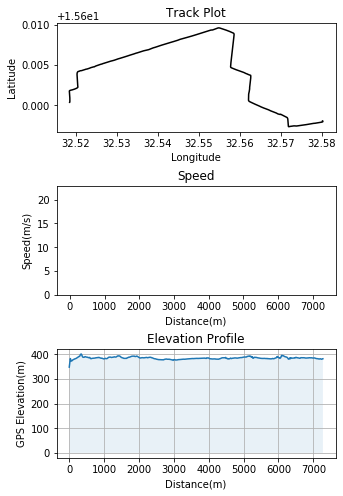

In [7]:
#Plotting
#Track
f,(track,speed,elevation)=plt.subplots(3,1)
f.set_figheight(8)
f.set_figwidth(5)
plt.subplots_adjust(hspace=0.5)
track.plot(lon_list,lat_list,'k')
track.set_ylabel("Latitude")
track.set_xlabel("Longitude")
track.set_title("Track Plot")

#Speed
speed.bar(d_list,speed_list,30,color='w',edgecolor='w')
speed.set_title("Speed")
speed.set_xlabel("Distance(m)")
speed.set_ylabel("Speed(m/s)")

#Elevation
base_reg=0
elevation.plot(d_list,h_list)
elevation.fill_between(d_list,h_list,base_reg,alpha=0.1)
elevation.set_title("Elevation Profile")
elevation.set_xlabel("Distance(m)")
elevation.set_ylabel("GPS Elevation(m)")
elevation.grid()

In [ ]:
#######################################################

In [8]:
#using gpxplotter
for track in read_gpx_file('Data/GPX/krt_18.gpx'):
    data= track   
#data['segments'][0]
time= pd.Series(data['segments'][0]['time'])
lats= pd.Series(data['segments'][0]['lat'])
lons= pd.Series(data['segments'][0]['lon'])
distance= pd.Series(data['segments'][0]['distance'])
elevation= pd.Series(data['segments'][0]['elevation'])
speed = pd.Series(data['segments'][0]['velocity'])
data= pd.DataFrame({'lat':lats, 'lon':lons, 'time':time, 'distance': distance, 'elevation': elevation, 'speed': speed})

In [9]:
#Plot on Folium
f = folium.Figure(width=500, height=500)

the_map = create_folium_map(tiles='openstreetmap').add_to(f)
# Add pre-defined tiles:
add_all_tiles(the_map)

for track in read_gpx_file('Data/GPX/krt_18.gpx'):
    for i, segment in enumerate(track['segments']):
        add_segment_to_map(the_map, segment, color_by= 'distance')

# Add layer control to change tiles:
folium.LayerControl(sortLayers=True).add_to(the_map)

# To store the map as a HTML page:
# the_map.save('map_001.html')

# To display the map in a Jupyter notebook:
the_map

In [10]:
def add_colored_line(the_map, segment, color_by, cmap='viridis',
                     line_options=None):
    """Add segment as a colored line to a map.

    Add a line colored by some value to the given map.

    Parameters
    ----------
    the_map : object like :py:class:`folium.folium.Map`
        The map to add the segment to.
    segment : dict
        The segment to add.
    color_by : string
        This string selects what property we will color the segment
        according to.
    cmap : string
        The colormap to use for coloring.
    line_options : dict
        Extra control options for drawing the line.

    """
    zdata = data[color_by]
    avg = (0.5 * (zdata[1:] + zdata[:-1])).dropna()
    minz, maxz = min(avg), max(avg)
    uniq = len(set(zdata))
    if uniq < 10:
        levels = uniq + 1
    else:
        levels = 10
    linmap = getattr(branca.colormap.linear, cmap)
    colormap = linmap.scale(minz, maxz).to_step(levels)
    colormap.caption = RELABEL.get(color_by, color_by)
    if line_options is None:
        line_options = {'weight': 6}
    line_options['weight'] = line_options.get('weight', 6)
    line = folium.ColorLine(positions=segment, colormap=colormap,
                            colors=avg, control=False, **line_options)
    line.add_to(the_map)
    the_map.add_child(colormap)

In [11]:
print(f'Total distance = {round(data.distance.max()/1000,2)} km')
print(f'Total time = {round((data.time[len(data)-1] - data.time[0]).seconds/60,2)} minutes')
print(f'Elevation change = {round(data.elevation.max()-data.elevation.min(),2)} m')
print(f'Average speed = {round(data.speed.mean()*1.61,2)} km/hr')

Total distance = 8.23 km
Total time = 28.55 minutes
Elevation change = 53.3 m
Average speed = 7.75 km/hr


In [ ]:
#the_map.save('test.html')

In [ ]:
##############################################################################

In [12]:
#data['gps_time'] = pd.to_datetime(df['gps_time'])
data = data.sort_values(by=['time'])

In [13]:
# Optimizing data to get it to Valhalla's Meili
df_trip_for_meili = data[['lon', 'lat', 'time']]
df_trip_for_meili.head()

,lon,lat,time
0,32.518530,15.600370,2022-09-28 16:17:53+00:00
1,32.518573,15.600412,2022-09-28 16:17:54+00:00
2,32.518587,15.600493,2022-09-28 16:17:55+00:00
3,32.518607,15.600552,2022-09-28 16:17:57+00:00
4,32.518582,15.600608,2022-09-28 16:17:58+00:00


In [14]:
# Preparing the request to Valhalla's Meili
meili_coordinates = df_trip_for_meili.to_json(orient='records')
meili_head = '{"shape":'
meili_tail = ""","search_radius": 150, "shape_match":"map_snap", "costing":"auto", "format":"osrm"}"""
meili_request_body = meili_head + meili_coordinates + meili_tail

In [15]:
# Sending a request to Valhalla's Meili

#url = "http://localhost:8002/trace_route"
url = "https://valhalla1.openstreetmap.de/trace_route"
headers = {'Content-type': 'application/json'}
data = str(meili_request_body)

r = requests.post(url, data=data, headers=headers)

In [16]:
if r.status_code == 200:    
        response_text = json.loads(r.text)

        resp = str(response_text['tracepoints'])

        resp = resp.replace("'waypoint_index': None", "'waypoint_index': '#'")
        resp = resp.replace("None", "{'matchings_index': '#', 'name': '', 'waypoint_index': '#', 'alternatives_count': 0, 'distance': 0, 'location': [0.0, 0.0]}")

        resp = resp.replace("'", '"')

        resp = json.dumps(resp)
        resp = json.loads(resp)
        
        df_response = pd.read_json(resp)
        df_response = df_response[['name', 'distance', 'location']]
                
        df_trip_optimized = pd.merge(df_trip_for_meili, df_response, left_index=True, right_index=True)
df_trip_optimized.head()

,lon,lat,time,name,distance,location
0,32.518530,15.600370,2022-09-28 16:17:53+00:00,,9.478,"[32.518617, 15.600384]"
1,32.518573,15.600412,2022-09-28 16:17:54+00:00,شارع علي عبد اللطيف,4.143,"[32.518611, 15.600418]"
2,32.518587,15.600493,2022-09-28 16:17:55+00:00,شارع علي عبد اللطيف,1.257,"[32.518598, 15.600495]"
3,32.518607,15.600552,2022-09-28 16:17:57+00:00,شارع علي عبد اللطيف,1.910,"[32.518589, 15.600549]"
4,32.518582,15.600608,2022-09-28 16:17:58+00:00,شارع علي عبد اللطيف,0.269,"[32.518579, 15.600608]"


In [17]:
for i, row in df_trip_optimized.iterrows():
        df_trip_optimized.at[i, 'longitude'] = df_trip_optimized.at[i,'location'][0]
        df_trip_optimized.at[i, 'latitude'] = df_trip_optimized.at[i,'location'][1]
        
        #saving all the geopoints that couldn't be snapped to road
        if df_trip_optimized.at[i, 'longitude'] == 0.0:
            df_trip_optimized.at[i, 'longitude'] = df_trip_optimized.at[i,'lon']
            df_trip_optimized.at[i, 'latitude'] = df_trip_optimized.at[i,'lat']
            
df_trip_optimized = df_trip_optimized.drop(['location', 'lon', 'lat'], 1)
df_trip_optimized.rename(columns={'longitude': 'lon', 'latitude':'lat'}, inplace= True)
df_trip_optimized['distance']= df_trip_optimized.distance.cumsum()*0.3048
df_trip_optimized.head()

,time,name,distance,lon,lat
0,2022-09-28 16:17:53+00:00,,2.888894,32.518617,15.600384
1,2022-09-28 16:17:54+00:00,شارع علي عبد اللطيف,4.151681,32.518611,15.600418
2,2022-09-28 16:17:55+00:00,شارع علي عبد اللطيف,4.534814,32.518598,15.600495
3,2022-09-28 16:17:57+00:00,شارع علي عبد اللطيف,5.116982,32.518589,15.600549
4,2022-09-28 16:17:58+00:00,شارع علي عبد اللطيف,5.198974,32.518579,15.600608


In [18]:
data= df_trip_optimized

f = folium.Figure(width=500, height=500)

the_map= folium.Map(location=[data.lat.median(), data.lon.median()],
                    zoom_start = 13, tiles='openstreetmap').add_to(f)
add_all_tiles(the_map)


#for i in range(len(data)):
#    folium.Marker(location= [data.iloc[i].lat, data.iloc[i].lon], fill_color='#43d9de', radius=1).add_to(the_map)
    
#folium.PolyLine(locations= list(zip(data.lat, data.lon)), popup= data.distance.sum()/1000).add_to(the_map)

folium.ColorLine(
        positions = list(zip(data.lat, data.lon)), # tuple of coordinates 
        colors = data.distance, # map each segment with the speed 
        colormap= ['b', 'r', 'y'],
        weight= 5,
        nb_steps= 100).add_to(the_map)
folium.Marker(location= [data.iloc[0].lat, data.iloc[0].lon],
              icon=folium.Icon(color='black', icon='home', prefix='fa'), popup= 'Start').add_to(the_map)
folium.Marker(location= [data.iloc[-1].lat, data.iloc[-1].lon],
              icon=folium.Icon(color='black', icon='bus', prefix='fa'), popup= 'Finish').add_to(the_map)


# Add layer control to change tiles:
folium.LayerControl(sortLayers=True).add_to(the_map)

# To store the map as a HTML page:
# the_map.save('map_001.html')

# To display the map in a Jupyter notebook:
the_map